In [1]:
import os
import sys
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

In [2]:
from torch.utils.data.dataset import Dataset

In [3]:
sys.path.insert(0,'..')
from config import global_config

In [4]:
training_file = '/home/ubuntu/dev/LaneNet-Pytorch/data/training_data/train.txt'
CFG = global_config.cfg

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        '''
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        '''
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


class LaneNetDataset(Dataset):
    def __init__(self, text_file, cfg, transform=False):
        # Set image size
        self.height, self.width = cfg.TRAIN.IMG_HEIGHT, cfg.TRAIN.IMG_WIDTH
        
        # Create a list with all image path
        # [[img, binary, instance], ...]
        self.data_locations = []
        with open(text_file, 'r') as f:
            for line in f:
                d = [a for a in line.rstrip('\n').split(' ')]
                self.data_locations.append(d)
          
        if transform == True:
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            self.rgb_transform = self._rgb_transform(mean, std)
            self.unnormalize = UnNormalize(mean, std)
            self.transform = transforms.Compose([transforms.ToTensor()])
        else:
            self.transform = None

    def __getitem__(self, index):
        '''Return 3 images (src, binary, instance)'''
        source_path, binary_path, instance_path = self.data_locations[index]
        source_img = Image.open(source_path)
        binary_img = Image.open(binary_path)
        instance_img = Image.open(instance_path)
        
        # resize images
        source_img = self._resize(source_img, interp=Image.BILINEAR)
        binary_img = self._resize(binary_img)
        instance_img = self._resize(instance_img)
        
        # if src_image should be transformed, then transform all other
        if self.transform:
            source_img = self.rgb_transform(source_img)
            binary_img = self.transform(binary_img)
            instance_img = self.transform(instance_img)
        else:
            source_img = np.array(source_img)
            binary_img = np.array(binary_img)
            instance_img = np.array(instance_img)
        
        return (source_img, binary_img, instance_img)

    def __len__(self):
        return len(self.data_locations)
    
    def _resize(self, img, interp=Image.NEAREST):
        '''
        Resize image based on config width and height
        Binary and instance images should not be interpolated with 
        bilinear algorithms since pixel values are valuable
        '''
        return img.resize((self.width, self.height), interp)
    
    def _rgb_transform(self, mean, std):
        '''Input image transfrom for VGG'''

        normalize = transforms.Normalize(mean=mean, std=std)
        transform = transforms.Compose([
            transforms.ToTensor(),
            normalize])

        return transform
    
    def rgb_normalize(self, tensor):
        '''Unnormalize rgb images'''
        return self.unnormalize(tensor)


In [6]:
dataset = LaneNetDataset(training_file, CFG)
print(len(dataset))

3626


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data = dataset[0]  # first data
type(data[0])

numpy.ndarray

(256, 512, 3)


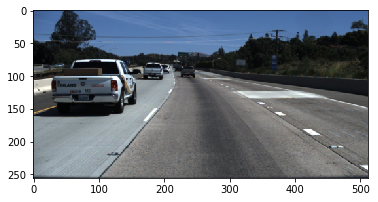

In [9]:
plt.imshow(data[0])
print(data[0].shape)

(256, 512)


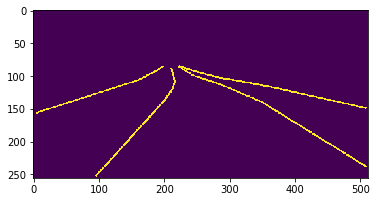

In [10]:
# Binary segmentation
plt.imshow(data[1])
print(data[1].shape)

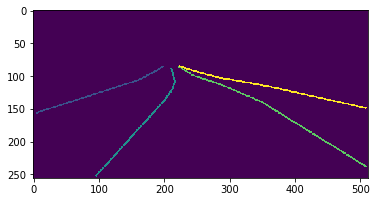

In [11]:
# Instance segmentation
plt.imshow(data[2])

In [12]:
dataset = LaneNetDataset(training_file, CFG, True)
print(len(dataset))

3626


In [13]:
data = dataset[0]  # first data

In [14]:
data[2]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [15]:
import torchvision.transforms.functional as VF

In [16]:
binary = VF.to_pil_image(data[1])

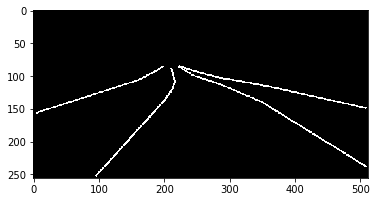

In [17]:
plt.imshow(binary)

In [18]:
instance = VF.to_pil_image(data[2])

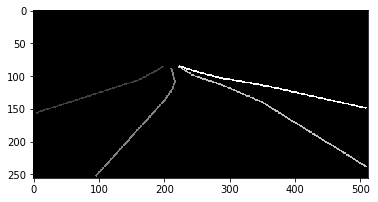

In [19]:
plt.imshow(instance)

In [20]:
src = VF.to_pil_image(dataset.rgb_normalize(data[0]))

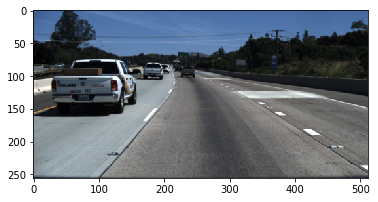

In [21]:
plt.imshow(src)